<a href="https://colab.research.google.com/github/jiaxinyyy/pytorch-tutorial/blob/master/W23_STATS161_hw7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 7.1

### Generate training Data

In [1]:
import numpy as np  
import matplotlib.pyplot as plt
import torch

from matplotlib import cm, ticker
import plotly.graph_objects as go

import torch

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
from sklearn.preprocessing import PolynomialFeatures

# Create a polynomial feature transformer
poly = PolynomialFeatures(degree=4)

def get_poly_features(X):
    X = poly.fit_transform(X)
    X = torch.tensor(X, dtype=torch.float32)
    return X

# True feature vector
theta_tru = torch.tensor([
    3.0619, -11.4365,  42.0929,  16.0846, -62.3337, -45.3745,  16.2397,
    6.8974,  18.5813, -25.6485,  14.6008, -14.0311,  12.6881, -35.1548,
    -16.3775])

/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<Axes: >

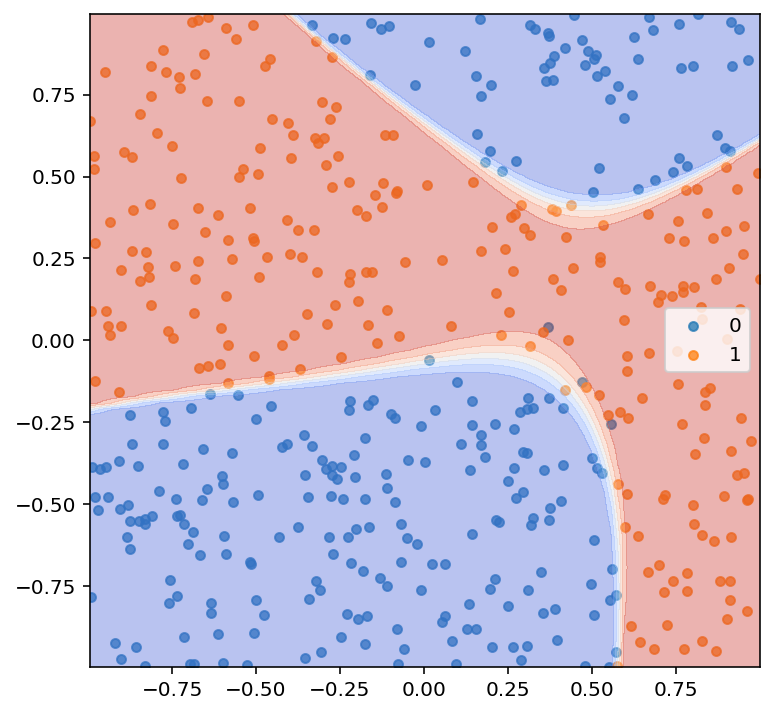

In [3]:
# generate data

# True model

from helpers import plot_decision_level_sets

n_train = 500
torch.manual_seed(42)

model_tru = lambda X: torch.sigmoid(get_poly_features(X) @ theta_tru)

def gen_data(n_samp):
    X = torch.rand(n_samp, 2) * 2 - 1 # Create a random features in [-1, 1] x [-1, 1]   
    prob = model_tru(X)
    y = torch.distributions.Bernoulli(prob).sample()
    y = y.view(-1,1)  # make it a column vector, super important!
    return X, y

# Generate training data
X_train, y_train = gen_data(n_train)

# plot decision boundary
plot_decision_level_sets(model_tru, X_train, y_train)

### 7.1a
A model for the logit of 𝑌 that is linear in the original features: ⟨$\theta$, 𝑋⟩.

In [4]:
def gd(loss, beta, lr=0.1, n_steps=50):
    """Perform gradient descent on a loss function."""
    loss_hist = np.zeros(n_steps)
    beta_list = [beta.clone()]
    for i in range(n_steps):
        curr_loss = loss(beta)
        loss_hist[i] = curr_loss.item()

        curr_loss.backward()

        with torch.no_grad():   
            beta -= lr * beta.grad

        beta.grad.zero_()
        beta_list.append(beta.clone())
    return loss_hist, beta_list

In [5]:
def loss(theta):
    z = X @ theta
    return torch.mean(-y_train * z + torch.log(1 + torch.exp(z)))

In [6]:
theta = torch.tensor([3, -3.], requires_grad=True)
X = X_train
loss_hist, theta_list = gd(loss, theta, lr=0.6, n_steps=1000) 

In [7]:
loss_hist[-1]

0.6931429505348206

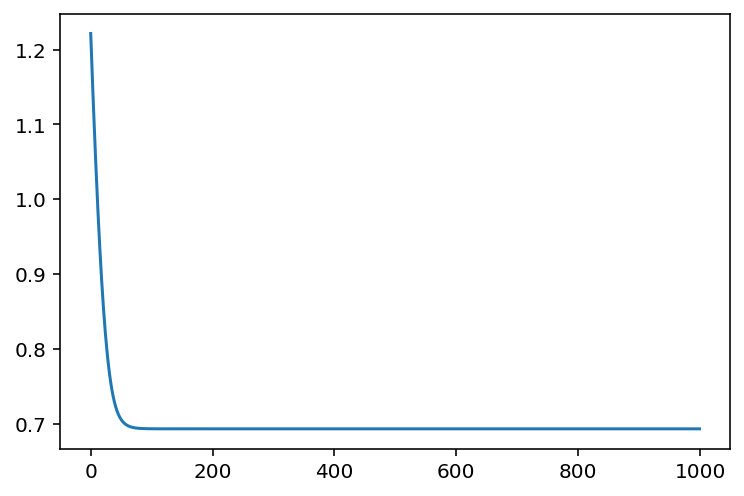

In [8]:
plt.plot(loss_hist)

### 7.1b

In [9]:
# Check what polynomial features look like
X_poly = get_poly_features(X_train)
print(X_poly.shape)
# What are the polynomial features?
poly.get_feature_names_out()

torch.Size([500, 15])


array(['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2', 'x0^3', 'x0^2 x1',
       'x0 x1^2', 'x1^3', 'x0^4', 'x0^3 x1', 'x0^2 x1^2', 'x0 x1^3',
       'x1^4'], dtype=object)

In [10]:
theta = torch.tensor([3, -3., 3, -3., 3, -3., 3,
                      3, -3., 3, -3., 3, -3., 3,
                      3], requires_grad=True)
X = X_poly
loss_hist, theta_list = gd(loss, theta, lr=0.6, n_steps=1000) 

In [11]:
loss_hist[-1]

0.696958601474762

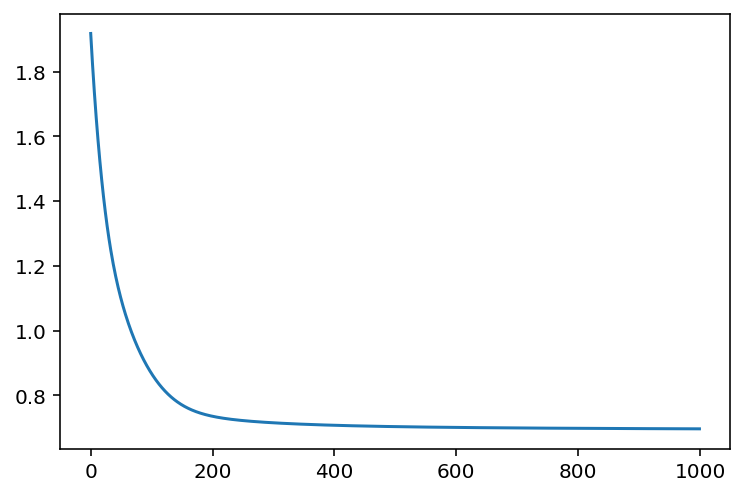

In [12]:
plt.plot(loss_hist)

The final training log-loss of the two models are both around 0.69.

## 7.2

In [13]:
from models import *

In [14]:
def log_loss(model):
  z = model(X_train) 
  return torch.mean(-y_train * z + torch.log(1 + torch.exp(z)))

In [15]:
model1_1 = nn.Sequential(nn.Linear(2,10), Dense(10,1))
model2_1 = nn.Sequential(Dense(2,10), nn.Linear(10,1))
model3_1 = nn.Sequential(Dense(2,10), Dense(10,5), nn.Linear(5,1))
model4_1 = nn.Sequential(Dense(2,10), Dense(10,5), Dense(5,10), nn.Linear(10,1)) 

In [16]:
from helpers import train
loss_hist1_1 = train(model1_1, log_loss, n_steps=20000, lr=1e-3, momentum=0.9)
loss_hist2_1 = train(model2_1, log_loss, n_steps=20000, lr=1e-3, momentum=0.9)
loss_hist3_1 = train(model3_1, log_loss, n_steps=20000, lr=1e-3, momentum=0.9)
loss_hist4_1 = train(model4_1, log_loss, n_steps=20000, lr=1e-3, momentum=0.9)

In [17]:
model1_2 = nn.Sequential(nn.Linear(2,10), Dense(10,1))
model2_2 = nn.Sequential(Dense(2,10), nn.Linear(10,1))
model3_2 = nn.Sequential(Dense(2,10), Dense(10,5), nn.Linear(5,1))
model4_2 = nn.Sequential(Dense(2,10), Dense(10,5), Dense(5,10), nn.Linear(10,1)) 

In [18]:
loss_hist1_2 = train(model1_2, log_loss, n_steps=10000, lr=1e-2, optimizer=torch.optim.Adam)
loss_hist2_2 = train(model2_2, log_loss, n_steps=10000, lr=1e-2, optimizer=torch.optim.Adam)
loss_hist3_2 = train(model3_2, log_loss, n_steps=10000, lr=1e-2, optimizer=torch.optim.Adam)
loss_hist4_2 = train(model4_2, log_loss, n_steps=10000, lr=1e-2, optimizer=torch.optim.Adam)

### 7.2a

Using GD with momentum

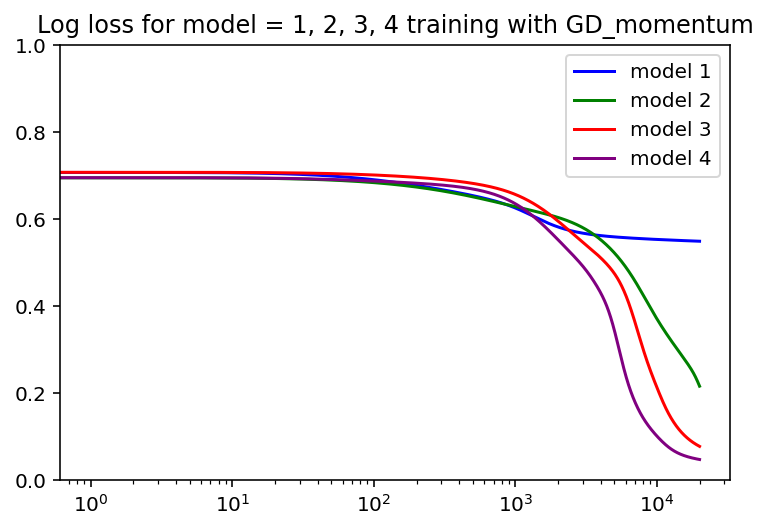

In [19]:
plt.plot(loss_hist1_1, color='blue', label='model 1')
plt.plot(loss_hist2_1, color='green', label='model 2')
plt.plot(loss_hist3_1, color='red', label='model 3')
plt.plot(loss_hist4_1, color='purple', label='model 4')

plt.xscale('log')
plt.ylim(0, 1)
plt.title("Log loss for model = 1, 2, 3, 4 training with GD_momentum")
plt.legend(loc=0)

In [20]:
print("The final training log-loss_for model 1 is " + str(loss_hist1_1[-1]))
print("The final training log-loss_for model 2 is " + str(loss_hist2_1[-1]))
print("The final training log-loss_for model 3 is " + str(loss_hist3_1[-1]))
print("The final training log-loss_for model 4 is " + str(loss_hist4_1[-1]))

The final training log-loss_for model 1 is 0.5483613014221191
The final training log-loss_for model 2 is 0.21504229307174683
The final training log-loss_for model 3 is 0.07661639153957367
The final training log-loss_for model 4 is 0.04645204916596413


Using the Adam optimizer

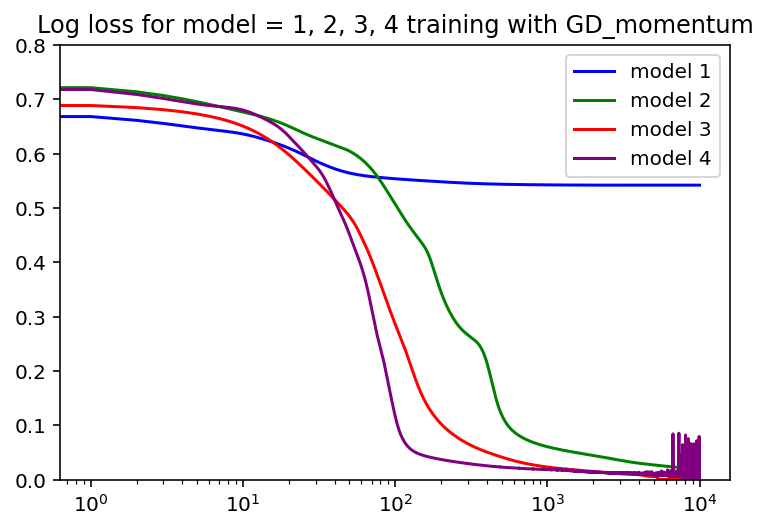

In [21]:
plt.plot(loss_hist1_2, color='blue', label='model 1')
plt.plot(loss_hist2_2, color='green', label='model 2')
plt.plot(loss_hist3_2, color='red', label='model 3')
plt.plot(loss_hist4_2, color='purple', label='model 4')

plt.xscale('log')
plt.ylim(0, 0.8)
plt.title("Log loss for model = 1, 2, 3, 4 training with GD_momentum")
plt.legend(loc=0)

In [22]:
print("The final training log-loss_for model 1 is " + str(loss_hist1_2[-1]))
print("The final training log-loss_for model 2 is " + str(loss_hist2_2[-1]))
print("The final training log-loss_for model 3 is " + str(loss_hist3_2[-1]))
print("The final training log-loss_for model 4 is " + str(loss_hist4_2[-1]))

The final training log-loss_for model 1 is 0.5418565273284912
The final training log-loss_for model 2 is nan
The final training log-loss_for model 3 is 2.8246264264453202e-05
The final training log-loss_for model 4 is 0.003388839541003108


It seems that both versions of model 3 and 4 work with training log loss going down considerably.

### 7.2b

Model 3 using both gd_momentum and Adam optimizer 

<Axes: >

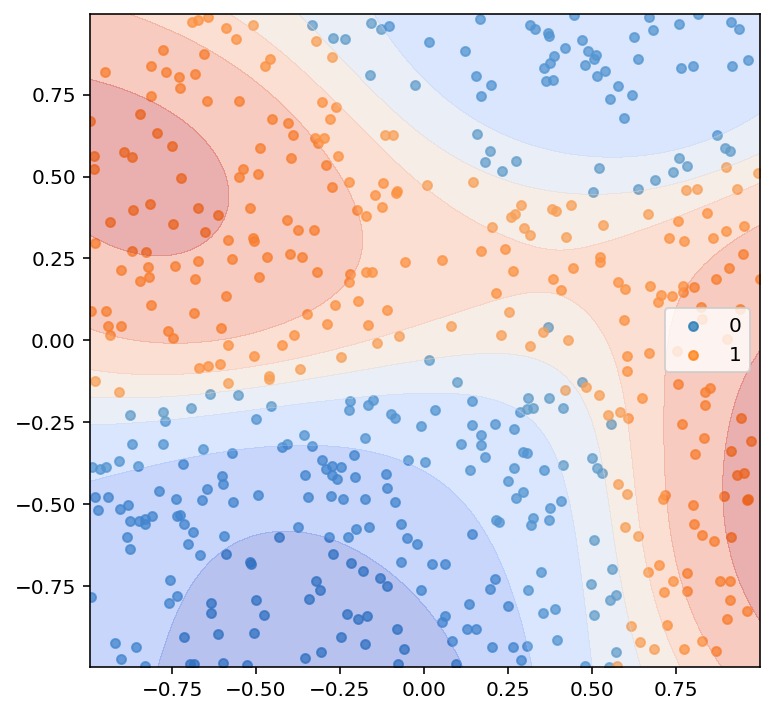

In [23]:
plot_decision_level_sets(model3_1, X_train, y_train)

<Axes: >

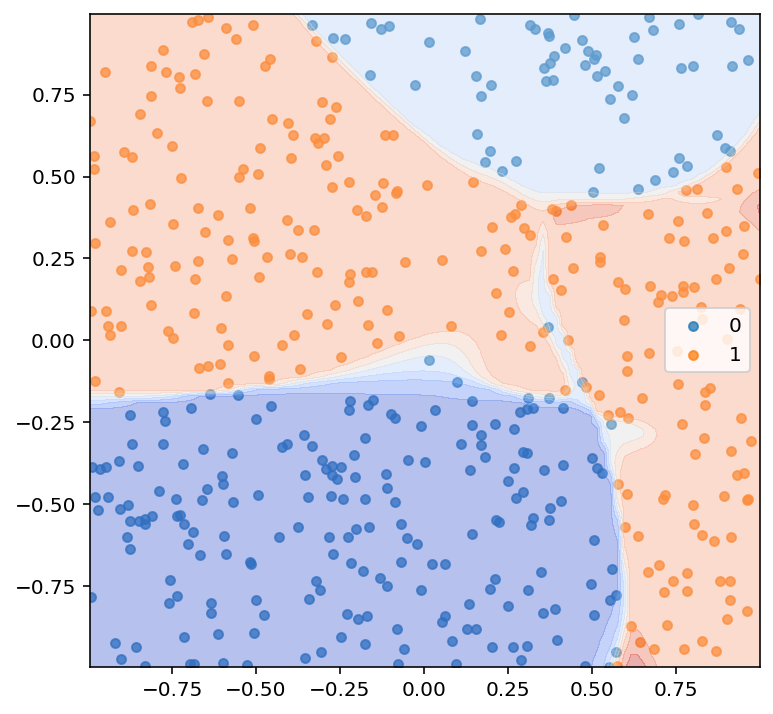

In [24]:
plot_decision_level_sets(model3_2, X_train, y_train)

Model 4 using both gd_momentum and Adam optimizer 

<Axes: >

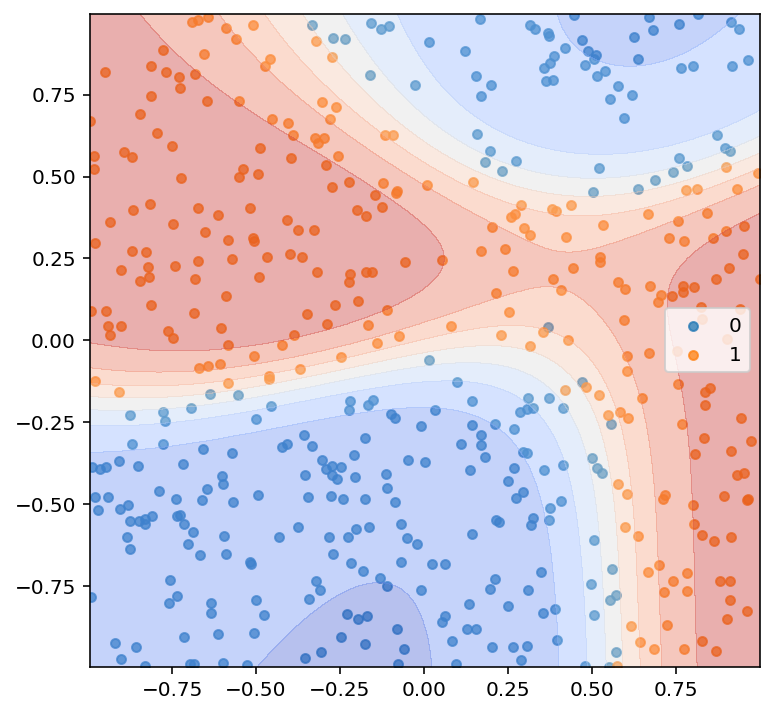

In [25]:
plot_decision_level_sets(model4_1, X_train, y_train)

<Axes: >

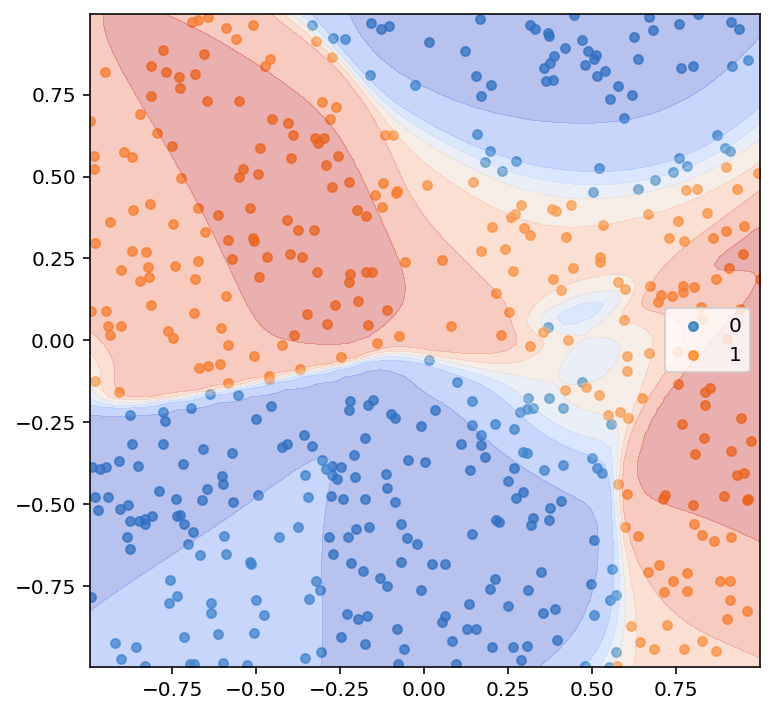

In [26]:
plot_decision_level_sets(model4_2, X_train, y_train)

### 7.2c

As plotted in 7.2b, the difference between the decision level sets is the model trained with gradient descent with momentum has larger areas of darker decicision levels, showing it has higher predicted probability of the two classes.